## Density-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html

In [5]:
import uproot
import numpy as np
from reco.plotting import plot_event, plot_remapped, plot_tracksters
from reco.evaluation import evaluate, evaluate_remapped, run_evaluation
from reco.event import remap_arrays_by_label, remap_items_by_label, get_bary, get_lc

from reco.energy import get_total_energy
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MeanShift
import awkward as ak
%matplotlib inline

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/Data/multi/new_ntuples_14992862_996.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 123, tracksters sim: 10
Simulated energy: 3423.19, reconstructed energy: 2886.56 (84.32%)


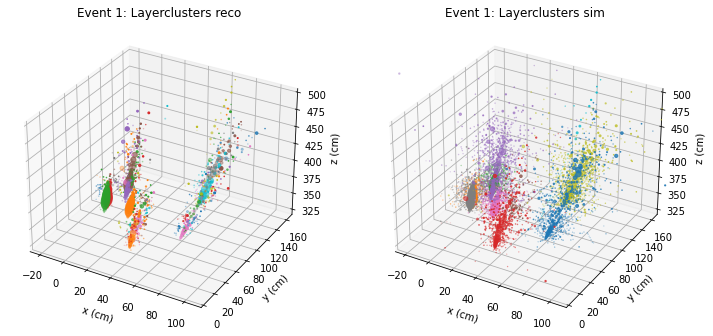

In [6]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [7]:
precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.97, Recall: 0.16, F-score: 0.28


In [8]:
X = get_bary(tracksters, eid)
X_vertices = get_lc(tracksters, eid)

## DBSCAN

Apply DBSCAN algorithm on CLUE3D barycentres and on layerclusters

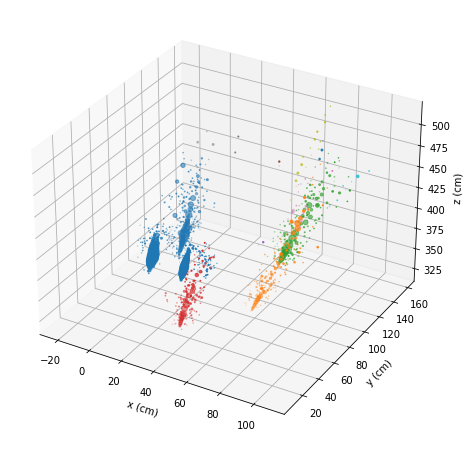

Tracksters: 11


(0.6652443220121684, 0.938051543994704, 0.7784383115156734)

In [19]:
# db on barycentres
# use min_samples=1 to prevent dropping tracksters

def dbscan_bary(tracksters, _eid, eps=20):
    X_bary = get_bary(tracksters, _eid)
    raw_e = sample_weight=tracksters["raw_energy"].array()[_eid]
    dbscan = DBSCAN(eps=eps, min_samples=1).fit(X_bary, sample_weight=raw_e)
    return dbscan.labels_

labels = dbscan_bary(tracksters, eid)
plot_remapped(tracksters, eid, labels)

print("Tracksters:", max(labels)+1)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

eps 16: components: 18, components with energy: 18
Precision: 0.74, Recall: 0.82, F-score: 0.78
Precision: 0.74, Recall: 0.82, F-score: 0.78
eps 17: components: 15, components with energy: 15
Precision: 0.74, Recall: 0.82, F-score: 0.78
Precision: 0.74, Recall: 0.82, F-score: 0.78
eps 18: components: 14, components with energy: 14
Precision: 0.67, Recall: 0.83, F-score: 0.74
Precision: 0.67, Recall: 0.83, F-score: 0.74
eps 19: components: 12, components with energy: 12
Precision: 0.67, Recall: 0.94, F-score: 0.78
Precision: 0.67, Recall: 0.94, F-score: 0.78
eps 20: components: 10, components with energy: 10
Precision: 0.67, Recall: 0.94, F-score: 0.78
Precision: 0.67, Recall: 0.94, F-score: 0.78
eps 21: components: 9, components with energy: 9
Precision: 0.67, Recall: 0.96, F-score: 0.79
Precision: 0.67, Recall: 0.96, F-score: 0.79
eps 22: components: 8, components with energy: 8
Precision: 0.67, Recall: 0.96, F-score: 0.79
Precision: 0.67, Recall: 0.96, F-score: 0.79
eps 23: component

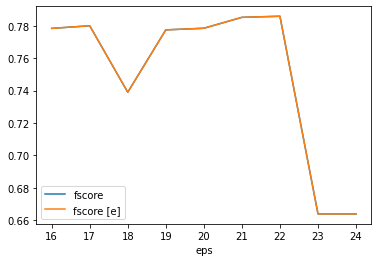

In [ ]:
# fine tune the eps
eps_range = np.arange(16, 25)

models = []
models_e = []

raw_e = sample_weight=tracksters["raw_energy"].array()[eid]

for eps in eps_range:
    woe = DBSCAN(eps=eps, min_samples=1).fit(X)
    we = DBSCAN(eps=eps, min_samples=1).fit(X, sample_weight=raw_e)
    print(f"eps {eps}: components: {max(woe.labels_)+1}, components with energy: {max(we.labels_)+1}")

    models.append(evaluate_remapped(woe.labels_)[2])
    models_e.append(evaluate_remapped(we.labels_)[2])

plt.plot(eps_range, models, label='fscore')
plt.plot(eps_range, models_e, label='fscore [e]')
plt.xlabel('eps')
plt.legend()

Tracksters: 9


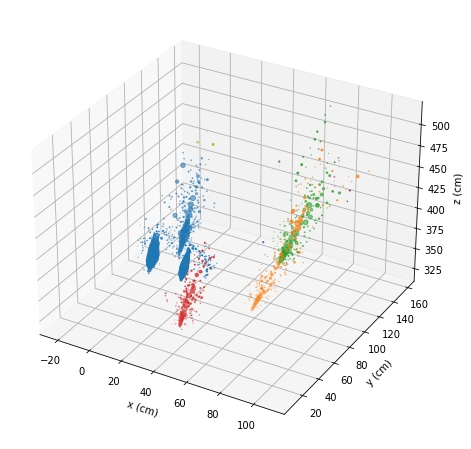

In [11]:
# dbscan on layerclusters
dbscan = DBSCAN(eps=12, min_samples=2).fit(X_vertices)
print("Tracksters:", max(dbscan.labels_)+1)

ri = remap_items_by_label(ak.flatten(t_indexes), dbscan.labels_)
re = remap_items_by_label(ak.flatten(t_energy), dbscan.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), dbscan.labels_)

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), dbscan.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), dbscan.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), dbscan.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [12]:
precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.66, Recall: 0.98, F-score: 0.79


## Meanshift

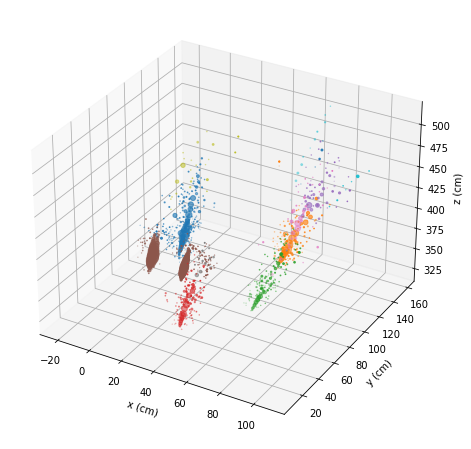

Tracksters: 12


(0.7483484506051207, 0.7314772887274957, 0.7398166974969995)

In [22]:
# meanshift on barycentres

def meanshift_bary(tracksters, _eid, bandwidth=25):
    X_bary = get_bary(tracksters, _eid)
    mshift = MeanShift(bandwidth=bandwidth).fit(X_bary)
    return mshift.labels_

labels = meanshift_bary(tracksters, eid)

plot_remapped(tracksters, eid, labels)
print("Tracksters:", max(labels)+1)
evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, labels, noise=False)

Tracksters: 12


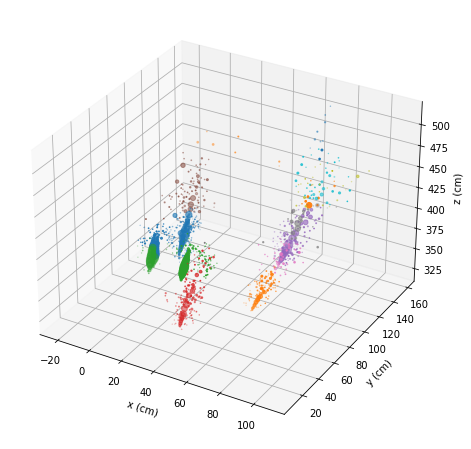

In [15]:
# meanshift on layerclusters
mshift = MeanShift(bandwidth=23).fit(X_vertices)
print("Tracksters:", max(mshift.labels_)+1)

ri = remap_items_by_label(ak.flatten(t_indexes), mshift.labels_)
re = remap_items_by_label(ak.flatten(t_energy), mshift.labels_)
rm = remap_items_by_label(ak.flatten(v_multi), mshift.labels_)

rx = remap_items_by_label(ak.flatten(tracksters["vertices_x"].array()[eid]), mshift.labels_)
ry = remap_items_by_label(ak.flatten(tracksters["vertices_y"].array()[eid]), mshift.labels_)
rz = remap_items_by_label(ak.flatten(tracksters["vertices_z"].array()[eid]), mshift.labels_)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

In [16]:
precision, recall, fscore = evaluate(ri, st_indexes, re, st_energy, rm, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.75, Recall: 0.62, F-score: 0.68


## Evaluation

In [21]:
run_evaluation(dbscan_bary, tracksters, simtracksters, eps=20)

Event 0: T_reco: 13, T_sim: 10 | p: 0.97 r: 0.93 f:0.95
Event 1: T_reco: 11, T_sim: 10 | p: 0.67 r: 0.94 f:0.78
Event 2: T_reco: 8, T_sim: 10 | p: 0.45 r: 0.94 f:0.61
Event 3: T_reco: 16, T_sim: 10 | p: 0.72 r: 0.73 f:0.73
Event 4: T_reco: 12, T_sim: 10 | p: 0.41 r: 0.85 f:0.55
Event 5: T_reco: 5, T_sim: 10 | p: 0.80 r: 0.98 f:0.88
Event 6: T_reco: 7, T_sim: 10 | p: 0.67 r: 0.97 f:0.79
Event 7: T_reco: 10, T_sim: 10 | p: 0.59 r: 0.90 f:0.71
Event 8: T_reco: 15, T_sim: 10 | p: 0.71 r: 0.77 f:0.74
Event 9: T_reco: 13, T_sim: 10 | p: 0.82 r: 0.89 f:0.85
Event 10: T_reco: 9, T_sim: 10 | p: 0.54 r: 0.90 f:0.67
Event 11: T_reco: 10, T_sim: 10 | p: 0.55 r: 0.83 f:0.66
Event 12: T_reco: 7, T_sim: 10 | p: 1.00 r: 0.99 f:1.00
Event 13: T_reco: 23, T_sim: 10 | p: 0.92 r: 0.75 f:0.82
Event 14: T_reco: 11, T_sim: 10 | p: 0.78 r: 0.84 f:0.81
Event 15: T_reco: 8, T_sim: 10 | p: 0.50 r: 0.92 f:0.65
Event 16: T_reco: 8, T_sim: 10 | p: 0.82 r: 0.98 f:0.89
Event 17: T_reco: 12, T_sim: 10 | p: 0.93 r: 0.8

In [23]:
run_evaluation(meanshift_bary, tracksters, simtracksters, bandwidth=25)

Event 0: T_reco: 9, T_sim: 10 | p: 0.76 r: 0.74 f:0.75
Event 1: T_reco: 12, T_sim: 10 | p: 0.75 r: 0.73 f:0.74
Event 2: T_reco: 11, T_sim: 10 | p: 0.66 r: 0.79 f:0.72
Event 3: T_reco: 14, T_sim: 10 | p: 0.74 r: 0.70 f:0.72
Event 4: T_reco: 11, T_sim: 10 | p: 0.46 r: 0.66 f:0.54
Event 5: T_reco: 5, T_sim: 10 | p: 0.80 r: 0.98 f:0.88
Event 6: T_reco: 8, T_sim: 10 | p: 0.66 r: 0.94 f:0.78
Event 7: T_reco: 12, T_sim: 10 | p: 0.74 r: 0.80 f:0.77
Event 8: T_reco: 13, T_sim: 10 | p: 0.74 r: 0.59 f:0.66
Event 9: T_reco: 12, T_sim: 10 | p: 0.81 r: 0.89 f:0.85
Event 10: T_reco: 9, T_sim: 10 | p: 0.70 r: 0.79 f:0.75
Event 11: T_reco: 10, T_sim: 10 | p: 0.58 r: 0.64 f:0.61
Event 12: T_reco: 8, T_sim: 10 | p: 1.00 r: 0.98 f:0.99
Event 13: T_reco: 20, T_sim: 10 | p: 0.94 r: 0.61 f:0.74
Event 14: T_reco: 8, T_sim: 10 | p: 0.56 r: 0.91 f:0.70
Event 15: T_reco: 10, T_sim: 10 | p: 0.62 r: 0.65 f:0.63
Event 16: T_reco: 9, T_sim: 10 | p: 0.54 r: 0.68 f:0.61
Event 17: T_reco: 12, T_sim: 10 | p: 0.87 r: 0.7